In [1]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()


import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

mode = 'train'


Using TensorFlow backend.


In [2]:
num_epochs = 20 #5000
batch_size = 16
learning_rate = 4e-3 #1e-4
decay_rate = 1e-3 # 1e-1

latent_dim = 512
epsilon_mean = 1.0
epsilon_std = 1e-2

In [3]:
output = np.log10(np.load("../data/Zeldotest.np.npy"))
output = (output - output.min() )/(output.max() - output.min())

swe_train = output[0:800,:,:]
swe_valid = output[800:1000,:,:]

swe_train = swe_train.reshape(800,64,64,1)
swe_valid = swe_valid.reshape(200,64,64,1)

# # Visualize transformations
# plt.figure()
# plt.imshow(swe_train[0].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[1].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[2].reshape(64,64))
# plt.show()
# exit()

# Shuffle
swe_train_data = np.copy(swe_train)
swe_valid_data = np.copy(swe_valid)

np.random.shuffle(swe_train_data)
np.random.shuffle(swe_valid_data)


def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [5]:
print(swe_valid.shape)
y_train = swe_train_data.reshape(800, 64*64)

(200, 64, 64, 1)


[0.02279685 0.04439687 0.06496116 0.0841471  0.10204092 0.11939955
 0.13564727 0.15172422 0.16719575 0.18259206 0.19735657 0.2111511
 0.22161408 0.23165137 0.24129491 0.25059706 0.2594534  0.26814591
 0.27663928 0.2849945  0.29331803 0.30117099 0.30900321 0.31648733
 0.32386534 0.3310845  0.33816419 0.34511581 0.35196473 0.35861537
 0.36525313 0.37162095 0.37789201 0.38400491 0.39001973 0.3958487
 0.40155697 0.40723338 0.41287843 0.4184401  0.42389346 0.42928407
 0.4344953  0.43966679 0.44476364 0.44979666 0.45465883 0.4594038
 0.46411832 0.46877501 0.47335861 0.47784888 0.48231278 0.48673766
 0.49108627 0.49534494 0.49946055 0.50355283 0.50760302 0.51155529
 0.51545802 0.51933385 0.52316076 0.5269671  0.53070214 0.53434595
 0.53796288 0.54155701 0.5450961  0.54862099 0.5521181  0.55560285
 0.55900037 0.56237238 0.56568549 0.56899007 0.57224629 0.57546455
 0.57863948 0.58176239 0.58484437 0.587902   0.5909237  0.5938994
 0.59685551 0.59978441 0.60268321 0.60553507 0.60833535 0.6111199


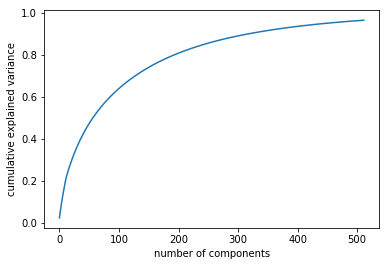

In [8]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=512)
principalComponents = pca_model.fit_transform(y_train)
pca_bases = pca_model.components_

plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
# print(np.cumsum(pca_model.explained_variance_ratio_))

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA

PCAmodel = 'PCAmodel'
def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)



In [12]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=latent_dim)

# pca_w_mean, pca_w_std, rescaled_pca_weights = rescale01(pca_weights)



original shape:    (800, 4096)
transformed shape: (800, 512)
bases shape: (512, 4096)


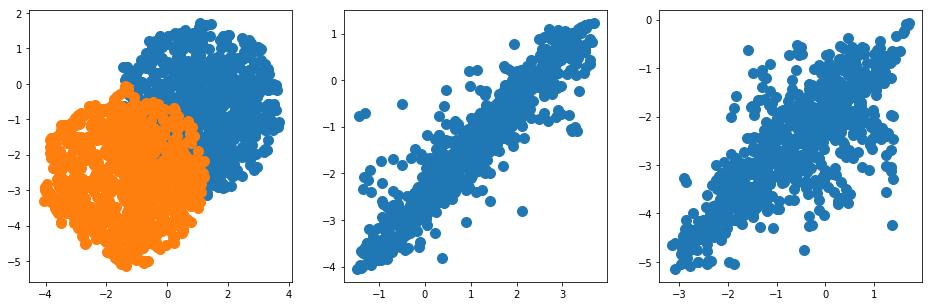

In [17]:
import umap
np.random.seed(5)
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_weights)
embedding0 = reducer.fit_transform(y_train)


f, a = plt.subplots(1, 3, figsize = (16,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None)

a[0].scatter(embedding[:, 0], embedding[:, 1], s = 100)
a[0].scatter(embedding0[:, 0], embedding0[:, 1], s = 100)

a[1].scatter(embedding[:, 0], embedding0[:, 0], s = 100)
a[2].scatter(embedding[:, 1], embedding0[:, 1], s = 100)

    # a[para_idx].scatter(embedding_r[:, 0], embedding_r[:, 1], c= parameter_array[:, para_idx], s = 100)


(1, 4096)


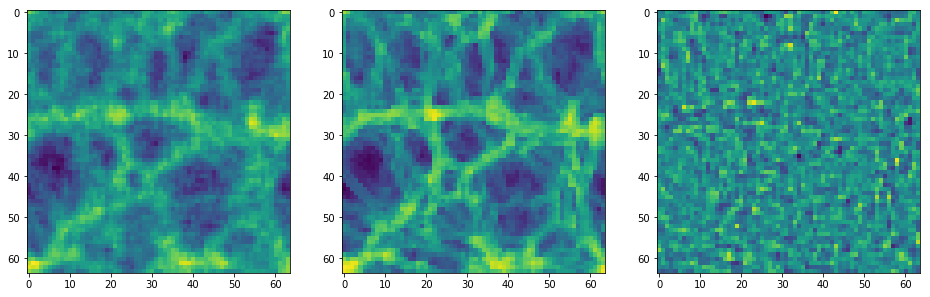

In [37]:
# W_predArray = pca_weights[43] #+ pca_weights[2]

# transform new data using already fitted pca
# (don't re-fit the pca)
y_test = swe_valid_data.reshape(200, 64*64)
y_test_ind = y_test[43][np.newaxis, :]
print(y_test_ind.shape)
W_predArray = pca_model.transform(y_test_ind)

recon = pca_model.inverse_transform(W_predArray).reshape(64, 64)

f, a = plt.subplots(1, 3, figsize = (16,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None)

a[0].imshow(recon)

a[1].imshow(y_test[43].reshape(64, 64))

a[2].imshow(recon - y_test[43].reshape(64, 64))


In [ ]:
W_predArray = pca_weights[43] + pca_weights[2]
recon = pca_model.inverse_transform(W_predArray).reshape(64, 64)

f, a = plt.subplots(1, 3, figsize = (16,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None)

a[0].imshow(recon)

a[1].imshow(y_train[43].reshape(64, 64))

a[2].imshow(recon - y_train[43].reshape(64, 64))
